# Week 10 Problem 3

If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_  → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.
-----
# Problem 10.3. Network Analysis

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1)

from nose.tools import assert_equal, assert_is_instance, assert_true, assert_is_not
from numpy.testing import assert_array_equal

------
## Number of Flights from ORD
In this problem, we are going to make a graph showing the number of flights from the `ORD` airport to all other airports using `~/data/2001/2001-1.csv`, which includes top 500,000 lines of our familiar `~/data/2001.csv` file. For this problem, only the two columns, `Origin` and `Dest`, are needed. Since we only care about flights departed from `ORD`, we could remove irrelavant rows from the dataframe. (In principle, we could make a graph of airline connections between all airports in the data; here we choose origin to be `ORD` just for simplicity.)

In [2]:
filename = '/home/data_scientist/data/2001/2001-1.csv'
flights = pd.read_csv(filename, header=0, na_values=['NA'], usecols=(16, 17)).dropna()

# remove all rows whose origin is not ORD
from_ord = flights.loc[flights['Origin']=='ORD'].dropna()
print(from_ord.tail(20))

       Origin Dest
496653    ORD  EWR
496654    ORD  EWR
496655    ORD  EWR
496656    ORD  EWR
496657    ORD  EWR
496658    ORD  EWR
496659    ORD  EWR
496660    ORD  EWR
496661    ORD  EWR
496935    ORD  CLE
496936    ORD  CLE
496937    ORD  CLE
496938    ORD  CLE
497123    ORD  IAH
497124    ORD  IAH
497125    ORD  IAH
498959    ORD  CLE
498960    ORD  CLE
498961    ORD  CLE
498962    ORD  CLE


### get_top_dests
- Write a function named `get_top_dests` that counts the number of flights from `ORD` to each destination in the input dataframe and returns top `n` destinations together with the count of each destination. 
- Each row of the input dataframe corresponds to one flight (one count). For example, 
```
497123    ORD  IAH
497124    ORD  IAH
497125    ORD  IAH
```
should add 3 counts for `IAH`.
- While there might be various ways to do the counting and selection, the most straight forward method that gives you the desired output form is to use `Counter`.

In [3]:
def get_top_dests(df=from_ord, n=50):
    '''
    Counts the number of flights from ORD to each destination in df,
    and returns top n destinations.
    
    Paramters
    ---------
    df: A pandas.DataFrame instance with two columns: 
        'Origin' and 'Dest'. Default: from_ord.
    n: Number of destinations selected. Default: 50.
    
    Returns
    -------
    A list of tuples ('Dest', count/number of occurrence) 
    in the form of (str, int).
    '''
    
    # empty counter
    cnt = Counter()
    for dest in df["Dest"]:
        cnt[dest] += 1
    top_dests = cnt.most_common(n)

    return top_dests

In [4]:
# print out the result
top_10_dests = get_top_dests(n=10)
print('{0:10} {1:}'.format('Dest', 'Count'))
print('-'*20)
for dest, count in top_10_dests:
    print('{0:10} {1:}'.format(dest, count))

Dest       Count
--------------------
MSP        1086
LGA        951
EWR        944
DFW        942
LAX        874
PHL        855
BOS        780
DCA        713
ATL        687
DTW        662


In [5]:
# assertions
t10_d = [d for d, c in top_10_dests]
t10_c = [c for d, c in top_10_dests]
assert_array_equal(t10_d, ['MSP', 'LGA', 'EWR', 'DFW', 'LAX', 'PHL', 'BOS', 'DCA', 'ATL', 'DTW'])
assert_array_equal(t10_c, [1086, 951, 944, 942, 874, 855, 780, 713, 687, 662])

### create_flights_graph
- Write a function named `create_flights_graph` that takes the top destinations (result from previous function in the form of a list of (`Dest`, count)) and creates a networkx Graph.
- Step through each destination airport to add egdes to the Graph. Note that nodes will be automatically added when you add edges. The edges connect destinations to `ORD`.
- For each edge, you should add a normalized weight (use `'weight'` as the key) which equals to the int value of count devided by the minimum count. We'll use weights of edges later when we draw the Graph.

In [6]:
def create_flights_graph(top_dests, start_node='ORD'):
    '''
    Creates a graph of number of flights originated from ORD to top destinations.
    
    Paramters
    ---------
    top_dests: A list of tuples ('Dest', count/number of occurrence) 
               in the form of (str, int).
    start_node: Default: 'ORD'.
    
    Returns
    -------
    A networkx.Graph instance.
    '''
    
    # build graph
    dg = nx.Graph()
    dg.add_node("ORD")

    # Build up list of edges and weights for controlled plotting
    weights = []
    for dest, count in top_dests:
        weights.append(count)

    # Make normalized weights (scale to minimum weight)
    min_weight = min(weights)
    norm_weights = [int(weight/min_weight) for weight in weights]

    for idx, val in enumerate(top_dests):
        if not val[0] == "ORD": # exclude the start node
            dg.add_edge("ORD", val[0], weight = norm_weights[idx])

    return dg

In [7]:
# construct the graph for top 50 destinations
top_50_dests = get_top_dests(n=50)
t_dg = create_flights_graph(top_50_dests)

In [8]:
# assertions
assert_is_instance(t_dg, nx.Graph)
assert_equal(len(t_dg.nodes()), len(top_50_dests)+1) # number of nodes = 50 dests plus ORD
assert_equal(len(t_dg.edges()), len(top_50_dests))

t50_d = [d for d, c in top_50_dests]
t50_d.append('ORD')
t50_c = [d for d, c in top_50_dests]
assert_equal(set(t_dg.nodes()), set(t50_d))

for start, end in t_dg.edges():
    assert_true(start in t50_d)
    assert_true(end in t50_d)
    
t50_w = []
for n1, n2, dct in t_dg.edges(data=True):
    if set([n1, n2])==set(['MSP', 'ORD']):
        assert_equal(dct['weight'], 5)
    if set([n1, n2])==set(['STL', 'ORD']):
        assert_equal(dct['weight'], 2)
    if set([n1, n2])==set(['RDU', 'ORD']):
        assert_equal(dct['weight'], 1)
    t50_w.append(dct['weight'])
assert_array_equal(np.sort(t50_w), [1]*31+[2]*9+[3]*5+[4]*4+[5])

### draw_flights_graph

- First, use networkx.draw_networkx_nodes() to draw the nodes.
- Next, use networkx.draw_networkx_edges() to draw the edges. The width of the line for each node corresponds to the normalized weight, which is contained in the edges data.
- Finally, use networkx.draw_networkx_labels() to draw the labels. 
- Use a spring layout.
- Several lines to improve the appearance of the image (for example, a white background is set and axes are removed) are provided. 

![](./images/from_ord.png)

In [22]:
def draw_flights_graph(dg):
    '''
    Draws the Graph 'dg' with a spring layout.
    
    Paramters
    ---------
    dg: A networkx.Graph instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    # some image formatting
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.despine(ax=ax, top = True, bottom = True, left = True, right = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    clrs = sns.color_palette("Paired")
    # use spring layout
    pos = nx.spring_layout(dg)
    
    # width = norm_weights
    weight_list = [val[2] for val in dg.edges(data = True)]
    norm_weights = []
    for weight in weight_list:
        norm_weights.append(weight["weight"])

    # Draw the nodes
    nx.draw_networkx_nodes(dg, pos, with_labels = True,
                           node_size = 1000,
                           node_color = clrs[0],
                           node_shape = 'o',
                           alpha = 0.4)

    # Draw the edges, with the norm_weights
    nx.draw_networkx_edges(dg, pos,
                           width = norm_weights,
                           edge_color = clrs.as_hex()[4],
                           alpha = 0.7)

    # Label the nodes
    nx.draw_networkx_labels(dg, pos, font_size = 12,
                            font_color = clrs[1],
                            alpha = 1.0)
    
    ax.set_title("Number of Flights from ORD")
    
    return ax

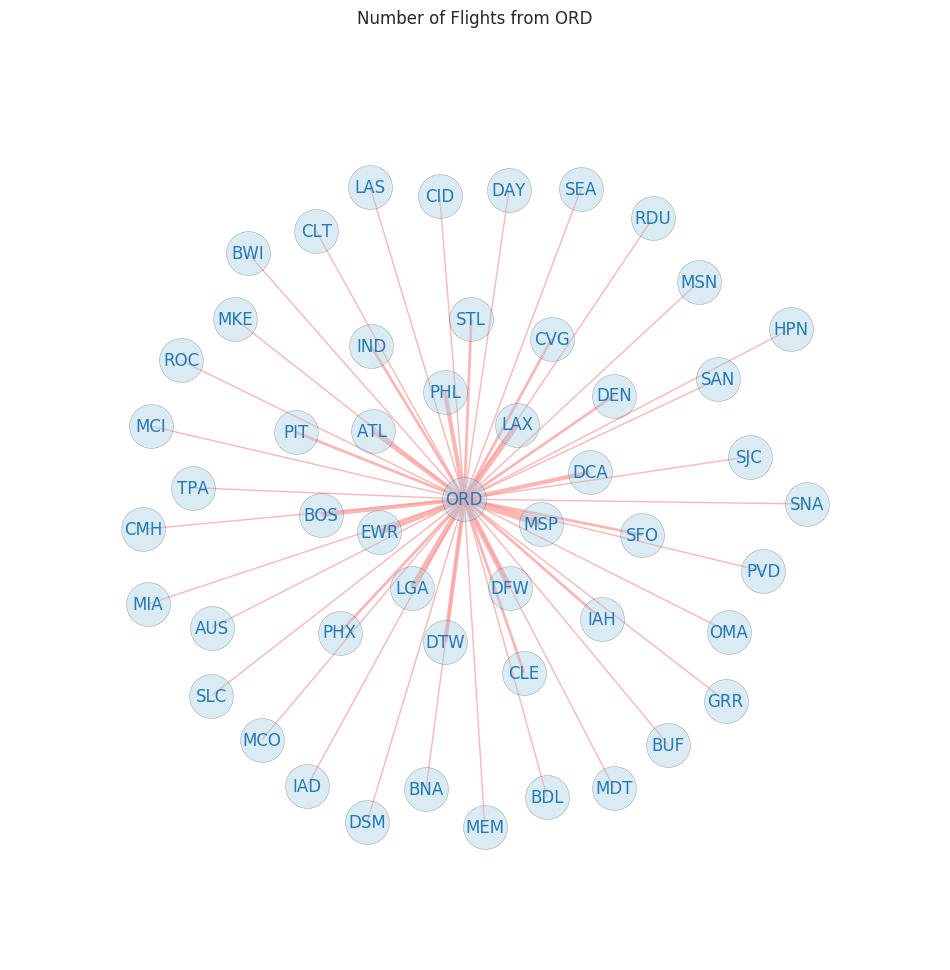

In [23]:
# draw the graph
t_ax = draw_flights_graph(t_dg)

In [11]:
# assertions
assert_is_instance(t_ax, mpl.axes.Axes)
assert_is_not(len(t_ax.title.get_text()), 0, msg="Your plot should have a title.")
assert_equal(t_ax.collections[0].get_offsets().shape[0], len(t_dg.nodes()))
assert_equal(len(t_ax.collections[1].get_segments()), len(t_dg.edges()))
assert_array_equal(np.sort(t_ax.collections[1].get_linewidth()), [1]*31+[2]*9+[3]*5+[4]*4+[5])

-----
## Common Movie Interests between 30 Users
In this problem, we are going to examine the common movie interests between first 30 users in `~/data/ml-latest-samll/ratings.csv` with `userId` from 1 to 30. If a user has given a rating equal to or above 4.0 points for a movie, we say that the user is interested in the movie. The following cell reads the csv file into a dataframe, and then do a selection based on these conditions (`rating`>=40 and `userId` from 1 to 30). 

In [12]:
filename2 = '/home/data_scientist/data/ml-latest-small/ratings.csv'
movies = pd.read_csv(filename2, header=0, usecols=(0, 1, 2)).dropna()

# name the selected dataframe as 'good_movies'
good_movies = movies[(movies['rating']>=4.0)&(movies['userId'].isin(np.arange(1, 31)))][['userId', 'movieId']]
print(good_movies.head(10))

    userId  movieId
0        1       16
2        1       32
3        1       47
4        1       50
5        1      110
7        1      161
10       1      223
12       1      260
15       1      296
16       1      318


In the selected dataframe `good_movies`, we say there's one common movie interest between two users if they both have rating records for the same movie in `good_movies`. For example, if `userId` 1 and `userId` 2 have both rated `movieId` 16, then we add one count to the common movie interests between user 1 and user 2. We'll make make a plot of common movie interests based on this definition.

### get_top_pairs
- Write a function named `get_top_pairs` that counts the number of common movie interests between any combination of two users in the input dataframe and returns top n paired users together with the count of numbers of common movies.
- As mentioned above, we add one count of common movies to a user pair if the two users in the pair have rated the same movie. For example, suppose we have these lines in `good_movies`,
```
    userId  movieId
0        1       16
2        1       32
3        2       16
4        2       32
```
then row 0 and 3 should contribute to one count for user pair (`userId` 1, `userId` 2), and row 2 and 4 add another count for user pair (`userId` 1, `userId` 2); thus, the total counts for user pair (`userId` 1, `userId` 2) is 2 from these four lines.
- Use `combinations` as iterators to make pairs, so that user pair (`userId` 1, `userId` 2) is considered identical as user pair (`userId` 2, `userId` 1), and only (`userId` 1, `userId` 2) is included in the result.
- While there might be various ways to do the counting and selection, the most straight forward method that gives you the desired output form is to use Counter.
- Note that this time, the output is a list of tuples (paired_users, count/number of occurrence) 
    in the form of (tuple, int), 
    i.e. a list of tuples(user1, user2, count/number of occurrence)
    in the form of (int, int, int). In the given example of the four lines, the output is `[(1, 2), 2]`. You'll automatically get this form using Counter. 

In [13]:
def get_top_pairs(df=good_movies, n=100):
    '''
    Counts the number of common movie interests for any combination
    of two users in df, and returns top n paired users.
    
    Paramters
    ---------
    df: A pandas.DataFrame instance with two columns: 
        'userId' and 'movieId'. Default: good_movies.
    n: Number of destinations selected. Default: 100.
    
    Returns
    -------
    A list of tuples (paired users, count/number of occurrence) 
    in the form of (tuple, int), 
    i.e. a list of tuples((user1, user2), count/number of occurrence)
    in the form of ((int, int), int).
    '''
    
    # YOUR CODE HERE
    # empty counter
    cnt = Counter()
    # convert dataFrame to list
    df_list = df.values.tolist()

    for pair in combinations(df_list, 2):
        if pair[0][1] == pair[1][1]:
            cnt[(pair[0][0], pair[1][0])] += 1
            
    all_pairs = cnt.most_common(df.shape[0])
    
    # sort all pairs based on User1 ID
    sorted_all_pairs = sorted(all_pairs, key = lambda data: (data[1], -data[0][0]), reverse = True)
    
    #get top n pairs
    top_pairs = sorted_all_pairs[0: n]
    
    return top_pairs

In [14]:
# print out the result
top_10_pairs = get_top_pairs(n=10)
print('{0:20} {1:}'.format('Paired Users', 'Count'))
print('--'*15)
for paired_users, count in top_10_pairs:
    print('{0:3},{1:3} {2:16}'.format(paired_users[0], paired_users[1], count))

Paired Users         Count
------------------------------
  4, 24               34
 28, 29               25
 17, 30               23
 11, 29               21
  1, 30               20
  1, 24               19
  7, 29               19
  1,  7               18
  7, 30               18
 24, 28               18


In [15]:
# assertions
p10_u = [u for u, c in top_10_pairs]
p10_c = [c for u, c in top_10_pairs]
assert_array_equal(p10_u[:5], [(4, 24), (28, 29), (17, 30), (11, 29), (1, 30)])
assert_equal(set(p10_u[5:7]), set([(7, 29), (1, 24)]))
assert_equal(set(p10_u[7:]), set([(24, 28), (7, 30), (1, 7)]))
assert_array_equal(p10_c, [34, 25, 23, 21, 20, 19, 19, 18, 18, 18])

### create_interests_graph

- Write a function named create_interests_graph that takes the top paired users (result from previous function in the form of a list of (paired users, count)) and creates a networkx Graph.
- Step through each user pair to add egdes to the Graph. Note that nodes will be automatically added when you add edges. The edges connect two paired users.
- For each edge, you should add a normalized weight (use 'weight' as the key) which equals to the int value of count devided by the minimum count. We'll use weights of edges later when we draw the Graph.

In [16]:
def create_interests_graph(top_pairs):
    '''
    Creates a graph of number of common movie interests count 
    between each user pair.
    
    Paramters
    ---------
    top_dests: A list of tuples (paired users, count/number of occurrence) 
               in the form of (tuple of (int, int), int).
    
    Returns
    -------
    A networkx.Graph instance.
    '''
    
    # YOUR CODE HERE
    # build graph
    dg = nx.Graph()

    # Build up list of edges and weights for controlled plotting
    weights = []
    for pair, count in top_pairs:
        weights.append(count)

    # Make normalized weights (scale to minimum weight)
    min_weight = min(weights)

    for pair, count in top_pairs:
        dg.add_edge(pair[0], pair[1], weight = int(count / min_weight))
 
    return dg

In [17]:
# construct the graph for top 100 user pairs
top_100_pairs = get_top_pairs(n=100)
p_dg = create_interests_graph(top_100_pairs)

In [18]:
# assertions
assert_is_instance(p_dg, nx.Graph)
assert_equal(len(p_dg.nodes()), 25)
assert_equal(len(p_dg.edges()), len(top_100_pairs))

p100_u = [u for u, c in top_100_pairs]
p100_n = np.unique(np.ravel(p100_u))
p100_s = [set(u) for u, c in top_100_pairs]
p100_c = [c for u, c in top_100_pairs]
assert_equal(set(p_dg.nodes()), set(p100_n))

for start, end in p_dg.edges():
    assert_true(start in p100_n)
    assert_true(end in p100_n)
    assert_true(set((start, end)) in p100_s)

p100_w = []
for n1, n2, dct in p_dg.edges(data=True):
    if set([n1, n2])==set((4, 11)):
        assert_equal(dct['weight'], 1)
    if set([n1, n2])==set((8, 19)):
        assert_equal(dct['weight'], 4)
    if set([n1, n2])==set((27, 30)):
        assert_equal(dct['weight'], 2)
    p100_w.append(dct['weight'])
assert_array_equal(np.sort(p100_w), [1]*54+[2]*17+[3]*14+[4]*10+[5]*3+[6]+[8])

### draw_interests_graph
- First, use networkx.draw_networkx_nodes() to draw the nodes.
- Next, use networkx.draw_networkx_edges() to draw the edges. The width of the line for each node corresponds to the normalized weight, which is contained in the edges data.
- Finally, use networkx.draw_networkx_labels() to draw the labels.
- This time, use a circular layout.
- Several lines to improve the appearance of the image (for example, a white background is set and axes are removed) are provided.
- Note that this function is almost identical to `draw_flights_graph`, but to get a pretty image, we cannot directly apply `draw_flights_graph`.
![](./images/common_interests.png)

In [24]:
def draw_interests_graph(dg):
    '''
    Draws the Graph 'dg' with a circular layout.
    
    Paramters
    ---------
    dg: A networkx.Graph instance.
    
    Returns
    -------
    A matplotlib.Axes instance.
    '''
    
    # some image formatting
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.despine(ax=ax, top = True, bottom = True, left = True, right = True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # YOUR CODE HERE
    clrs = sns.color_palette("Paired")
    # use spring layout
    pos = nx.circular_layout(dg)
    
    # width = norm_weights
    weight_list = [val[2] for val in dg.edges(data = True)]
    norm_weights = []
    for weight in weight_list:
        norm_weights.append(weight["weight"])

    # Draw the nodes
    nx.draw_networkx_nodes(dg, pos, with_labels = True,
                           node_size = 1000,
                           node_color = clrs[0],
                           node_shape = 'o',
                           alpha = 0.4)

    # Draw the edges, with the norm_weights
    nx.draw_networkx_edges(dg, pos,
                           width = norm_weights,
                           edge_color = clrs.as_hex()[4],
                           alpha = 0.6)

    # Label the nodes
    nx.draw_networkx_labels(dg, pos, font_size = 14,
                            font_color = clrs[1],
                            alpha = 1.0)
    
    ax.set_title("Common Movie Interests between 30 Users")
        
    return ax

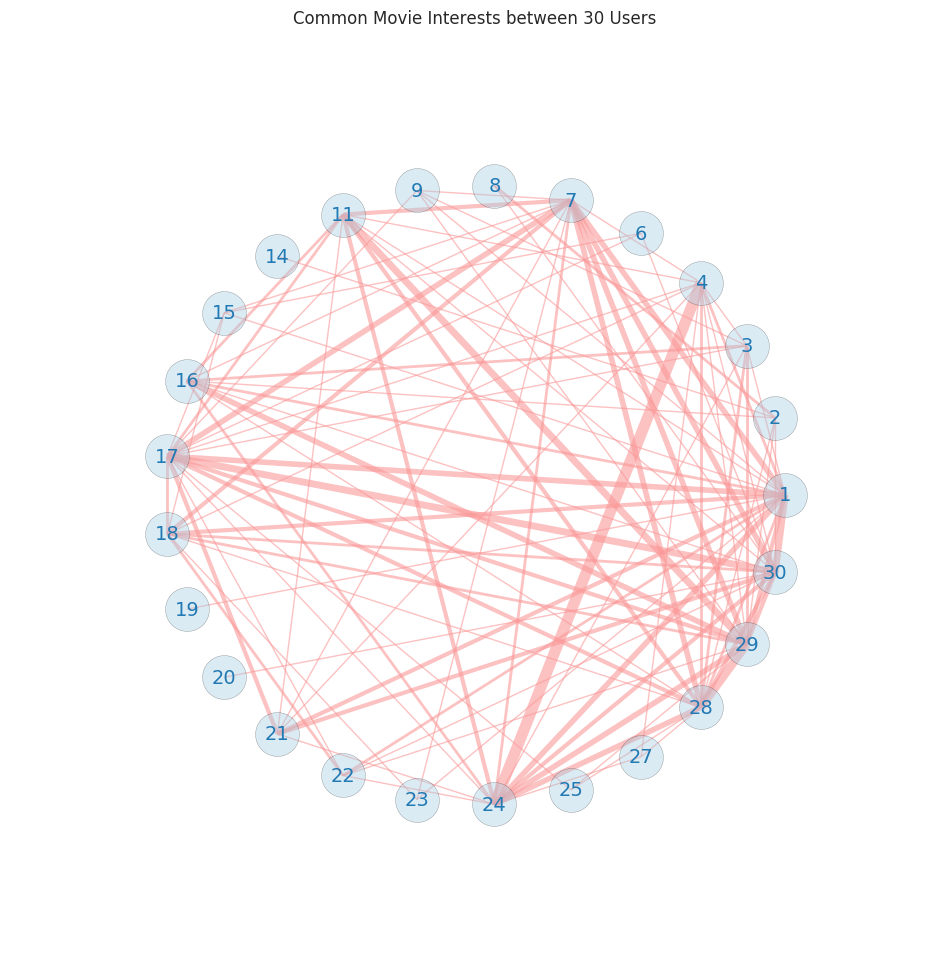

In [25]:
# draw the graph
p_ax = draw_interests_graph(p_dg)

In [26]:
# assertions
assert_is_instance(p_ax, mpl.axes.Axes)
assert_is_not(len(p_ax.title.get_text()), 0, msg="Your plot should have a title.")
assert_equal(p_ax.collections[0].get_offsets().shape[0], len(p_dg.nodes()))
assert_equal(len(p_ax.collections[1].get_segments()), len(p_dg.edges()))
assert_array_equal(np.sort(p_ax.collections[1].get_linewidth()), [1]*54+[2]*17+[3]*14+[4]*10+[5]*3+[6]+[8])